## Linear regression

This assignment is dedicated to Linear regression. 12 task, 30 points max.

By focusing on predicting different features of football players,
you will:
* gain understanding of mathematics behind Linear Regression model
* and become familiar with using `sklearn` library for solving this kind of tasks

In the assignment we will:
* build Linear regression models with 1 and many variables
* use both library methods and manual calculations using mathematical formulas
* implement main regression metrics to evaluate performance of our models
* explore limitations of classical linear regression

### Notes:
* do not modify `assert` blocks in code. They are used to check your results
    

### Data
- In this notebook we will work with Football Player attributes per each match played.
  
  Data is taken from [European Soccer Database](https://www.kaggle.com/hugomathien/soccer) dataset. 
  
  The table used is `Player_Attributes`.


### Materias

Start with the assignment first. Use materials below as references when needed.

* NumPy:
    - [quickstart](https://numpy.org/doc/stable/user/quickstart.html)
    - [api reference](https://numpy.org/doc/stable/reference/index.html)
    

* Pandas:
    - [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
    - guide on [groupby.transform](https://pandas.pydata.org/docs/user_guide/groupby.html#transformation). 
      used in one of tasks on data preprocessing
    - [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
    

* sklearn:
    - [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) class documentation
    - guide on [Linear models](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)


* Matplotlib:
    - [cheatsheet](https://matplotlib.org/cheatsheets/)
    - examples of [main plot types](https://matplotlib.org/stable/plot_types/index.html)
    - [scatter plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) documentation

In [281]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = 'raise'  # forbid chained assignment to prevent implicit errors

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 6)  # set default figure size

import seaborn as sns
sns.set(font_scale=1.1)  # increase default font scale and set seaborn's plot style

from typing import List, Iterable

## Data Processing

In [282]:
data_root_dp = os.path.join(r'C:\Users\Lenovo\Documents', 'Learning', 'Python', 'ML-intro', 'Pandas', 'Task 1')  # change to yours path
print(f'data_root_dp: "{data_root_dp}"')

data_root_dp: "C:\Users\Lenovo\Documents\Learning\Python\ML-intro\Pandas\Task 1"


### read the raw SQL data
* you can run this code only once.<br>
  it will read `.sqlite` file and save extracted data to a more handy `.csv` format

In [283]:
import sqlite3

 # open connection to .sqlite file
data_sql_fp = os.path.join(data_root_dp, 'database.sqlite')
print(f'will read from: "{data_sql_fp}"')
con = sqlite3.connect(data_sql_fp)

df = pd.read_sql('select * from Player_Attributes', con)  # run SQL-query
print(f'shape: {df.shape}')
con.close()  # close connection to .sqlite file

 # save to .csv
out_fp = os.path.join(data_root_dp, 'tmp', 'player_attributes.csv')
os.makedirs(os.path.dirname(out_fp), exist_ok=True)  # create directories if needed
print(f'will save to: "{out_fp}"')
df.to_csv(out_fp, index=False)

will read from: "C:\Users\Lenovo\Documents\Learning\Python\ML-intro\Pandas\Task 1\database.sqlite"
shape: (183978, 42)
will save to: "C:\Users\Lenovo\Documents\Learning\Python\ML-intro\Pandas\Task 1\tmp\player_attributes.csv"


### read the  data

In [284]:
data_player_attributes_fp = os.path.join(data_root_dp, 'tmp','player_attributes.csv')
print(f'reading from: "{data_player_attributes_fp}"')
df = pd.read_csv(data_player_attributes_fp)
print(df.shape)

reading from: "C:\Users\Lenovo\Documents\Learning\Python\ML-intro\Pandas\Task 1\tmp\player_attributes.csv"
(183978, 42)


In [285]:
df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

### basic data processing

In [286]:
# there are 3 'id' columns in data. 
# we will use 'player_api_id' only
# and drop other 'id' columns.
redundant_key_columns = ['id', 'player_fifa_api_id']

# also we will drop categorical columns for this task.
categorical_columns = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

cols_to_drop = redundant_key_columns + categorical_columns
print(f'will drop following columns: {cols_to_drop}')
df.drop(columns=cols_to_drop, inplace=True)

# rename 'player_api_id' column to shorter one: 'id'.
df.rename(columns={'player_api_id': 'id'}, inplace=True)

# cast string values to datetime
df['date'] = pd.to_datetime(df['date'])

# drop records that contain only NaNs in features
all_features = set(df.columns).difference(['id', 'date'])  # all columns without key columns
df.dropna(subset=all_features, how='all', inplace=True)

print(f'df.shape: {df.shape}')

will drop following columns: ['id', 'player_fifa_api_id', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
df.shape: (183142, 37)


In [287]:
# the dataset we're working with might get updated in future (new records might be added).
# thus we remove any records with date larger than the current max date in data (2016-07-07)
# for compatibility with current version of notebook.
df.drop(index=df[df['date'] > '2016-07-07'].index, inplace=True)
print(df.shape)

(183142, 37)


### drop duplicates

* we should **ALWAYS** understand what our data represents


* here we are dealing with Football Player attributes per each match played.

  so we expect the data to have `(id, date)` as a key
  
  
* let's check whether our assumption holds

In [288]:
df.duplicated(['id', 'date']).value_counts()

False    183142
dtype: int64

* there are no duplicates if considering `(id, date)` pair as a key

In [289]:
df.duplicated('id').value_counts()

True     172082
False     11060
dtype: int64

* and there are duplicates if considering only `id` column as a key
* so our assumption holds. But let's work only with latest stats for each player

#### Task 1. Keep only latest data for each player (1 point)

* HINT: you can use 

  `df[<new_column>] = df.groupby(<key_to_aggregate>)[<column>].transform('max')` 
  
  to get the `max` value of `<column>` for each group specified by `<key_to_aggregate>` columns.
  
  then you'll have to filter rows using `<column>` and `<new_column>` values
  

* don't forget to remove any additional columns you introduce here

In [290]:
# your code here
df['latest data'] = df.groupby('id')['date'].transform('max')
df.drop(df.loc[df['latest data'] != df['date']].index, inplace = True)
df.drop('latest data', axis = 1, inplace = True)
print(df.shape)

(11060, 37)


In [291]:
assert df.duplicated(['id']).sum() == 0
assert df.shape == (11060, 37)

In [292]:
# no longer need 'id' and 'date' columns
df.drop(columns=['id', 'date'], inplace=True)

### NaNs

In [293]:
df.isna().sum()

overall_rating          0
potential               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility               478
reactions               0
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                478
penalties               0
marking                 0
standing_tackle         0
sliding_tackle        478
gk_diving               0
gk_handling             0
gk_kicking              0
gk_positioning          0
gk_reflexes             0
dtype: int64

* do you see any pattern in how NaNs are distributed?
 
 There are same ammount (478 or 4,5%) of NaN values in columns:
 - volleys (удар с лета),
 - curve (крученый удар, навес или прострел)
 - agility (ловкость)
 - balance (удержания на ногах при физическом контакте)
 - jumping (высота прыжка)
 - vision (способность оценить положение партнера по команде/противника)
 - sliding_trackle (сыграть в мяч при выполнении подката)

In [294]:
df.isna().sum(axis=1).value_counts()

0    10582
7      478
dtype: int64

#### Task 2. Drop rows that contain NaNs (1 point)

In [295]:
df.dropna(inplace = True)

In [296]:
assert df.isna().sum().sum() == 0

Drop was implemented correctly

## Task 3. Implement main regression metrics yourself (up to 4 points):
* Mean Squared Error (mse) - **(1 point)**
* Mean Absolute Error (mae) - **(1 point)**
* Mean Absolute Percentage Error (mape) - **(1 point)**
* R-squared (r2) - **(1 point)**


#### bonus point: MAPE is implemented in such way to take possible 0 in `y_true` into account
Hints:

* you should divide on 
  $ \hat{y}_{true} = (\hat{y}_{true}^{(0)}, \hat{y}_{true}^{(1)}, ..., \hat{y}_{true}^{(n)}) $,
  
  where $ \ \ \hat{y}_{true}^{(i)} = max(\ \ | y_{true}^{(i)} |, \ \ \epsilon), \ \ \epsilon > 0, \ \ y_{true}^{(i)} \in \mathbb R $
  

* for compatibility with `sklearn` take 

  `eps = np.finfo(np.float64).eps`
  
  
#### bonus point: $R^2$ is implemented in such way to take possible 0 in numerator and denominator into account
Hints:

* recall the formula: $ R^2 = 1 - \dfrac{SS_{residuals}}{SS_{total}} $


* you should return:

    $
    \begin{cases}
     R^2 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} \ne 0 
     \\
     0 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} = 0 
     \\
     1 & \text { otherwise }
    \end{cases}
    $
    

* for a better understanding of $R^2$ coefficient 
  try to explain to yourself why we return those values in each of edge cases

$MSE$ - Mean Squared Error (среднеквадратичная ошибка)

$MAE$ - Mean Absolute Error (средняя абсолютная ошибка)

$MAPE$ - Mean Absolute Percentage Error (mape) (средняя абсолютная процентная ошибка)

$R^2$ -  R-squared (квадрат коэффициента детерминации) 

$R^2$ показывает насколько хорошо модель описывает данные. Если $R^2$ равно $1$, то регрессионная прямая совпадает со всеми эмпирическими точками, т.е. данные идеально скоррелированны. Если $R^2$ равно $0$, то вариация зависимой переменной полностью объясняется неученными факторами в модели, т.е. данные нескоррелированы, регрессионная прямая не отражает зависимость между x и y 
 

In [297]:
# we use '*' in the beggining of each function signature
# to forbid positional arguments and enforce the use of kwargs.
# this helps to avoid mistake when arguments are passed in wrong order.

# write down code instead of raising NotImplementedError in each of functions below.

def mse(*, y_true, y_pred):
    df_y = pd.DataFrame({ 'y_true' : y_true,
                          'y_pred' : y_pred })
    return df_y.apply(lambda x: (x.max()-x.min())**2, axis = 1).sum()/df_y.shape[0]  
        
def mae(*, y_true, y_pred):
    df_y = pd.DataFrame({ 'y_true' : y_true,
                          'y_pred' : y_pred })
    return df_y.apply(lambda x: x.max()-x.min(), axis = 1).sum()/df_y.shape[0]  
    
def mape(*, y_true, y_pred):
    df_y = pd.DataFrame({ 'y_true' : y_true,
                          'y_pred' : y_pred })
    epsilon = np.finfo(np.float64).eps
    df_y['y_true_eps'] = df_y['y_true']
    df_y.loc[abs(df_y['y_true_eps']) < epsilon, 'y_true_eps'] = epsilon
    return abs((df_y['y_true']-df_y['y_pred'])/df_y['y_true_eps']).sum()/df_y.shape[0] 
    
def r2(*, y_true, y_pred):
    df_y = pd.DataFrame({ 'y_true' : y_true,
                          'y_pred' : y_pred })
    y_true_mean = df_y.y_true.mean()
    SStot = ((df_y.y_true - y_true_mean)**2).sum()/df_y.shape[0]
    SSres = ((df_y.y_true - df_y.y_pred)**2).sum()/df_y.shape[0]
    
    if (SStot != 0 and SSres != 0):
        return 1 - SSres/SStot
    elif (SStot == 0 and SSres != 0):
        return 0    
    else: 
        return 1

### Validate your implementations are correct

* we'll use synthetic data for this task


In [298]:
from sklearn.metrics import (
    mean_squared_error as mse_lib, 
    mean_absolute_error as mae_lib,
    mean_absolute_percentage_error as mape_lib,
    r2_score as r2_lib
)

In [299]:
def compare_metrics(fn, fn_lib, y_true, y_pred, n_digits=9):
    #Print and compare values of custom and library functions using given precision
    m_fn = fn(y_true=y_true, y_pred=y_pred)
    m_fn_lib = fn_lib(y_true=y_true, y_pred=y_pred)
    print(f'{fn.__name__} custom : {m_fn}')
    print(f'{fn.__name__} library: {m_fn_lib}')
    print()
    assert round(m_fn, n_digits) == round(m_fn_lib, n_digits)

#### a case with a good fit

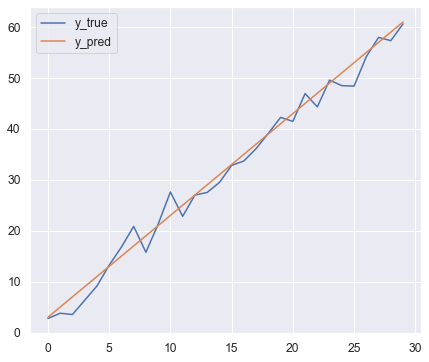

In [300]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [301]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 4.430556489001156
mse library: 4.430556489001156

mae custom : 1.6677052138321957
mae library: 1.6677052138321957

mape custom : 0.11248579908285701
mape library: 0.11248579908285701

r2 custom : 0.9852185432499964
r2 library: 0.9852185432499965

all tests passed


#### 0s in target. MAPE should explode

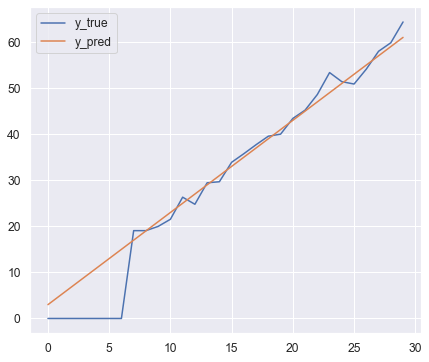

In [302]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_true[:7] = 0
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [303]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 24.611454265393423
mse library: 24.611454265393423

mae custom : 3.0658844088351733
mae library: 3.0658844088351733

mape custom : 9457559217478042.0
mape library: 9457559217478042.0

r2 custom : 0.9417735574827133
r2 library: 0.9417735574827133

all tests passed


#### edge cases for R2

r2 custom : 0
r2 library: 0.0

success


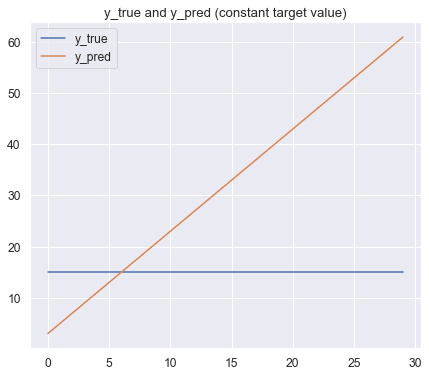

In [304]:
# constant target value

n = 30
x = np.arange(n)
y_true = np.repeat(15, n)
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.title('y_true and y_pred (constant target value)')
plt.legend();

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 1
r2 library: 1.0

success


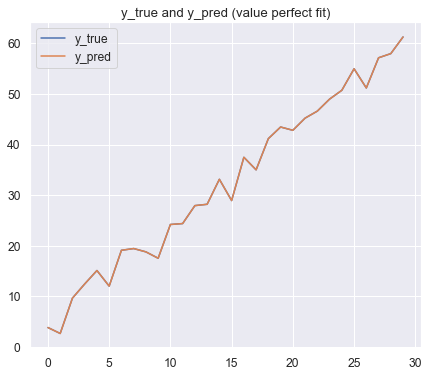

In [305]:
# perfect fit

n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = y_true

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.title('y_true and y_pred (value perfect fit)')
plt.legend();

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

- 1st case: constant target value

y_pred is constant and as we may suppose it isn't good fit for y_train, which is variable array. Visually, we can see it on the first plot. Numerically, r2 is 0, it mean that sets isn't correlated  
- 2st case: perfect fit

y_pred is perfectly correspond to y_train. Visually we can see the same curve on the plot. Numerically, r2 is 1, it mean that data is perfectly correlated

### Define helper functions

In [306]:
def get_metrics(*, y_true, y_pred) -> pd.Series:
    #A helper function to return all metrics for given labels and predictions. 
    
    return pd.Series({
        'mse': mse(y_true=y_true, y_pred=y_pred),
        'mae': mae(y_true=y_true, y_pred=y_pred),
        'mape': mape(y_true=y_true, y_pred=y_pred),
        'r2': r2(y_true=y_true, y_pred=y_pred),
    })

In [307]:
def fit_and_evaluate(model, x_train, y_train, x_test, y_test) -> pd.DataFrame:
    #A helper function to: fit a passed model and return metrics on train and test sets.

    # fit the model
    model.fit(x_train, y_train)
    
    # return metrics as pd.DataFrame
    m = pd.DataFrame([
        get_metrics(y_true=y_train, y_pred=model.predict(x_train)),  # metrics for train set
        get_metrics(y_true=y_test, y_pred=model.predict(x_test))     # metrics for test set
    ], index=['train', 'test']
    )
    
    return m

Функция get_metrics возвращает серию из метрик (mse, mae, mape и r2)

Функция fit_and_evaluate производит обучение тренировочной модели model с данными x_train и y_train. Возвращает датафрейм, столбцы которых содержат метрики по тренировочной зависимости и предсказанной

## train/test split

* Split the data we have into Train and Test splits with 80%/20% proportion

In [308]:
print(df.shape)
ix_split = int(0.8 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(8465, 35) (2117, 35)


In [309]:
def get_train_test_data(features: List[str], target: str) -> tuple:
    #Return x_train, y_train, x_test, y_test using global train/test split features and target provided.
    
    # in general, it's a bad practice to use global variables. 
    # however, we use it here with caution for simplicity.
    return (
        DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), 
        DF_TEST[features].copy(), DF_TEST[target].copy()
    )

Вспомогательная функция, позволяет выделить фреймы тренировочных и тестируемых данных

## Linear regression with 1 variable

* Let's start with Linear Regression that predicts target variable 
  using only 1 predictor (independent variable)  

* We will try to predict `dribbling` variable using `short_passing` as a predictor

In [310]:
target = 'dribbling'
features = ['short_passing']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

dribling - навык ведение мяча в обводку, полагаясь на собственные силы

short passing (короткий пас) — навык, определяющий точность и силу передачи мяча футболисту своей команды по низу

### Let's visualize our data first

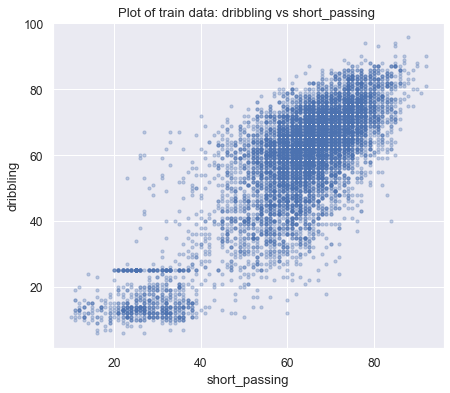

In [311]:
plt.scatter(x=x_train, y=y_train, alpha=0.3, s=10);
plt.title('Plot of train data: dribbling vs short_passing ')
plt.xlabel('short_passing');
plt.ylabel('dribbling');

* do you notice anything interesting on this plot?
* if so, how can we use it later to generate more accurate predictions?

Изображенная на графике зависимость имеет в общем пропорциональный и линейный характер. Данные должны быть хорошо скоррелированы

### Task 4. Compute Pearson correlation coefficient between feature and target (1 pont)
Hint: you can use either `pd.Series.corr` method or `np.corrcoef` function

In [312]:
print(x_train['short_passing'].corr(y_train, method = 'pearson', min_periods=None))
print(x_test['short_passing'].corr(y_test, method = 'pearson', min_periods=None))

0.8094048458494035
0.8268093866890012


feature и target хорошо скоррелированы в обоих наборах данных. Это подтверждает визуально определенную ранее на графике зависимость для тренировочного набора данных  

### Solve using `sklearn`

* we will use `LinearRegression` class from `sklearn` library 
  to fit a linear regression model and use it to generate prediction

In [313]:
from sklearn.linear_model import LinearRegression

In [314]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [315]:
model_intercept = model.intercept_
model_slope = model.coef_[0]
print(f'model_intercept: {model_intercept}')
print(f'model_slope: {model_slope}')

model_intercept: -6.2110299050262014
model_slope: 1.0366141627766277


Для регрессии с одной переменной:
intercept - свободный коэффициент прямой модели,т.е.значение target при feature = 0

slope - tg угола наклона прямой модели

Угол наклона примерно 45град, прямая проходит через точку (0;-6,2), что хорошо описывает ранее изображенный график 

* use fitted model to get predictions for test set

In [316]:
model_preds = model.predict(x_test)
model_preds

array([55.98581986, 65.31534733, 44.58306407, ..., 62.20550484,
       54.9492057 , 76.71810312])

* explore model quality on test set.

In [317]:
print('model metrics on test set')
metrics_test_1 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_1

model metrics on test set


mse     108.345801
mae       8.173553
mape      0.205500
r2        0.681477
dtype: float64

* can you explain what those metic values mean?

средняя абсолютная процентная ошибка составляет ~20% (среднеквадратичное отклонение ~108, средняя абсолютная ошибка ~8)

коэффициент детерминации равен ~0,68, что является хорошим показателем достоверности. Это означает, что предсказанные значения хорошо коррелируются с тестовыми, модель предсказывает target (dribbling) со средней ошибкой ~20%. 

#### Task 5. Calculate predictions for test set manually (1 point)

Above we used `LinearRegression.predict()` method to obtain predictions. 
Now let's do it manually!

Recall Linear Regression formula:

* $ \hat{y} = w_0 + w_1 \cdot x, $ 

    where:
    * $w_0$ is an intercept
    * $w_1$ is a slope
    * $x$ is a predictor
    * $\hat{y}$ is a predicted variable
  

* use intercept and slope values from fitted LinearRegression model

In [318]:
# use `x_test` for calculations as is (it's a DataFrame with 1 column).
# do not convert it to Series or numpy array.

# your code here:
model_manual_preds = x_test[:].apply(lambda x: model_intercept + model_slope*x, axis = 1)

In [319]:
assert isinstance(model_manual_preds, pd.DataFrame)

In [320]:
# ensure our manual predictions are the same as model generated
assert np.allclose(model_preds, model_manual_preds.iloc[:, 0].to_numpy())
print('success')

success


#### Task 6. Plot test data and predicted values (1 point)

* use `plt.scatter` function as in example above.
* first build scatter plot for test data
* then build scatter plot with model predictions
* add plot title, axis names and legend

Hints:
* use `alpha` parameter to control opacity and `s` parameter to control size of points.
  this will make plot more readable
* use `label` parameter to add label to each set of points added to scatter plot
* use different color for model predictions. control with parameter `color`

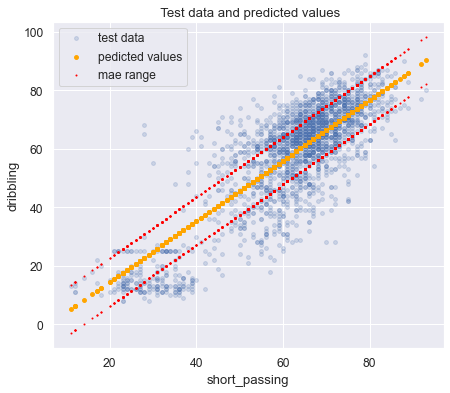

In [321]:
# your code here
# plt.scatter(...)
# plt.scatter(...)
# plt.legend(...);  # adds legend to a plot

plt.scatter(x=x_test, y=y_test, alpha=0.2, s=15, label='test data')
plt.scatter(x=x_test, y=model_preds, alpha=1, s=15, label='pedicted values', color = 'orange')
plt.scatter(x=x_test, y=model_preds+metrics_test_1[1], alpha=1, s=1, label='mae range', color = 'red')
plt.scatter(x=x_test, y=model_preds-metrics_test_1[1], alpha=1, s=1, color = 'red')

plt.title(' Test data and predicted values')
plt.xlabel('short_passing');
plt.ylabel('dribbling');
plt.legend();

Из графика видно, что предсказанные значения (прямая predicted values) хорошо коррелируются с тестовыми (test data), визуализированы метрики. Модель хорошо предсказывает target

### Task 7.  Fit regression model manually (3 points)

So far we have used `sklearn` library to fit linear regression model and obtain predictions. Good job!

Recall the formula of Linear regression for 1 variable:

* $ \hat{y} = w_0 + w_1 \cdot x $

Now let's try to fit the model **ourselves**.

### Theory

Assume our dataset consists of _n_ samples.

To fit a Linear regression model means to find the best set of parameters - 
$(w_0, w_1)$ that minimizes a **Loss function**.<br>
In case of Linear regression we choose **Residual sum of squares (RSS)** as a Loss function:

* $ L(w, x, y) = RSS(w, x, y) = \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

That is conceptually the same as minimizing Mean squared error (MSE):

* $ MSE(w, x, y) = \dfrac{1}{n} \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

Here:
* $y = (y_0, y_2, ..., y_{n-1}) $ - is a vector of target values we want to predict.
  1 value per each sample in our dataset that consists of _n_ samples
* $\hat{y} = (\hat{y}_0, \hat{y}_2, ..., \hat{y}_{n-1}) $ - is a vector of predictions 
* $\hat{y}_i = w_0 + w_1 \cdot x_i$ - is an individual prediction for _i_-th sample in a dataset

---

Best parameters $w_0$ and $w_1$ can be found using **following formulas**:

* $w_0 = \bar{y} - w_1 \cdot \bar{x}$


* $w_1 = \dfrac{\sum_{i=0}^{n-1}(x_i - \bar{x}) (y_i - \bar{y})}{\sum_{i=0}^{n-1}(x_i - \bar{x})^2}$


* where:
 * $\bar{x} = \dfrac{1}{n} \sum_{i=0}^{n-1}x_i$ - is the mean of vector $x$
 
 * $\bar{y} = \dfrac{1}{n} \sum_{i=0}^{n-1}y_i$ - is the mean of vector $y$
 
You should use these formulas to find the best model parameters in this task.
 
---

If you want to learn more you can refer to 
[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) wiki-page.

It contains analagous formula for $w_1$ coefficient that is conceptually the same 
(so it's not a bug in our formula provided above).

### Implementation

* convert pd.DataFrame and pd.Series (`x_train` and `y_train` respecitvely) to numpy-arrays

In [322]:
x = x_train.iloc[:, 0].to_numpy()
y = y_train.to_numpy()

* calculate model parameters ($w_1$ - slope and $w_0$ - intercept) using formulas given above

In [323]:
# # your code here:
manual_slope = np.sum((x-x.mean())*(y-y.mean()))/np.sum((x-x.mean())**2)
manual_intercept = y.mean()-manual_slope*x.mean()

In [324]:
print(f'manual_intercept: {manual_intercept}')
print(f'manual_slope: {manual_slope}')

manual_intercept: -6.211029905026031
manual_slope: 1.0366141627766248


In [325]:
assert round(model_intercept, 9) == round(manual_intercept, 9)
assert round(model_slope, 9) == round(manual_slope, 9)
print('success')

success


## Linear regression with multiple variables

* Now let's use Linear Regression model that uses multiple variables

* We will try to predict `dribbling` variable using 
  `['ball_control', 'short_passing', 'strength', 'sprint_speed']` features

In [326]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's explore the data first

In [327]:
cols = features + [target]
print(cols)

['ball_control', 'short_passing', 'strength', 'sprint_speed', 'dribbling']


#### Task 8 (1 point)

Build pairwise correlation matrix for selected features and target. Visualize it with heatmap.

Hints:
* use `DF_TRAIN` to build statistics (`x_train` contains only features. target is in `y_train`)
* use `pd.DataFrame.corr()` to build correlation matrix
* use `sns.heatmap` to build heatmap from correlation matrix. 
  * use `center` parameter to center your heatmap's colormap at 0
  * use diverging colormap (`cmap` parameter)<br>
    you can find the list of diverging colormaps
    [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging)<br>
    the reason is that we need to easily find both negative and positive correlations.
  * use `annot` parameters to add numbers to the plot.
* you can print `pd.DataFrame` and build plot in the same cell.<br> 
  use `display(...)` function that accets `pd.DataFrame` before building the plot
  
You can refer to [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) documentation

,ball_control,short_passing,strength,sprint_speed,dribbling
ball_control,1.000000,0.904857,-0.024422,0.572677,0.919271
short_passing,0.904857,1.000000,0.039196,0.450801,0.809405
strength,-0.024422,0.039196,1.000000,-0.203386,-0.150197
sprint_speed,0.572677,0.450801,-0.203386,1.000000,0.656453
dribbling,0.919271,0.809405,-0.150197,0.656453,1.000000


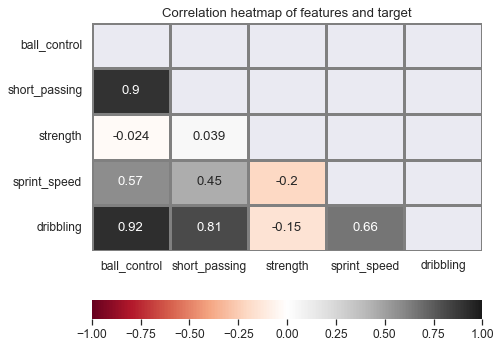

In [328]:
correlation_matrix = DF_TRAIN[cols].corr()
display(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, mask=np.triu(correlation_matrix), cbar_kws= {'orientation': 'horizontal'}, 
            vmin=-1, vmax=1, center= 0, cmap= 'RdGy', linewidths=3, linecolor='grey')
plt.title('Correlation heatmap of features and target')
plt.show()

* what can you say about selected feature set using this correlation matrix?

Correlation heatmap shows that among given features 'ball_control' and 'short_passing' most correlated with target 'dribbling'. Featute 'spirit_speed' is less correlated with 'dribbling' then first two. The least correlation with target has feature 'strength', it means that it's hardly to predict (by using only this feature) how its change will affect the target. High correlation also has feature 'ball_control' with 'short_passing'. It may influence on model's coefficents

#### Let's build pairplots for features and target

* `plot_kws` parameter accepts dictionary of keyword arguments 
  that are passed to bivariate plotting function (`sns.scatterplot` in this case)


* we set size to 7 (using `s` parameter) to make points smaller and see patterns clearly.<br>
  you can compare this to running with not `plot_kws` passed.
  

* `alpha` parameter also helps to see data distribution clearly


* you can also experiment with `kind` parameter - refer to
  [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
  documentation for possible values.

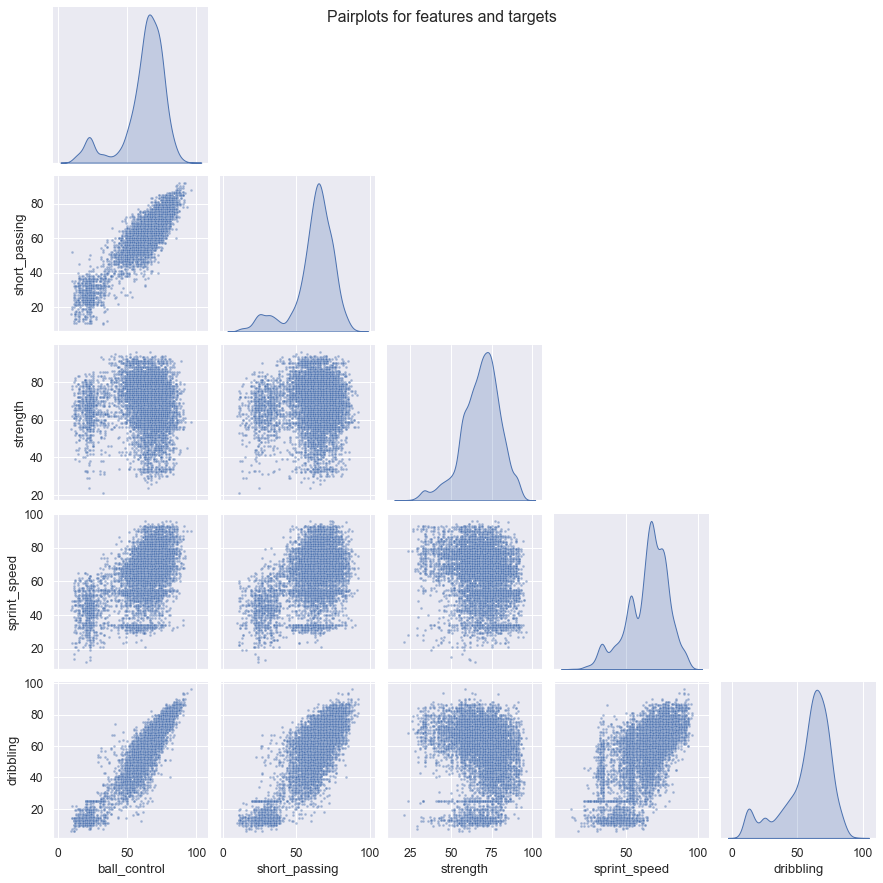

In [329]:
pl = sns.pairplot(DF_TRAIN[cols], plot_kws={'s': 7, 'alpha': 0.5}, diag_kind="kde", corner=True)
pl.fig.suptitle('Pairplots for features and targets')
plt.show()

* what can you say about these scatterplots? is there anything we can use later?

All features have similar unimodal and negatively skewed distrubution. As from heatmap, two features 'ball_control' and 'short_passing' most correlated with each other and target. Featute 'spirit_speed' is less correlated with target. All of them directly proportional. Feature 'strength' is weak correlated with 'dribbling', common dependency is inversely propotional. intuitively, feature 'strength' must be used with small 'weight'(coefficient) for target prediction. 

 ### Solve using `sklearn`

In [330]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [331]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')
print(f'model_features: {features}')

model_intercept: -4.410760994496734
model_coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]
model_features: ['ball_control', 'short_passing', 'strength', 'sprint_speed']


* how to interpret these model parameters?

Model_intercept is about -4.4 means that regression model is shifted down from origin. 

Feature 'ball_control' is most correlated with target, so it has the highest coefficient. Feature 'ball_control' and 'short_passing' are well correlated and feature 'short_passing' correct the 'ball_control' contrubution by having a very small negative coefficient. Feature 'strenght' is weak negatively correlated with target, so it has negative small coefficient. Feature 'spirit_speed' is less correlated with target then 'ball_control', so it has smaller coefficient. 

* use fitted model to get predictions for test set

In [332]:
model_preds = model.predict(x_test)
model_preds

array([44.30711902, 61.5246943 , 56.23794497, ..., 64.14903371,
       57.22105591, 75.15698321])

* explore model quality on test set.

In [333]:
print('model metrics on test set')
metrics_test_2 = get_metrics(y_true=y_test, y_pred=model_preds)
metrics_test_2

model metrics on test set


mse     38.192447
mae      4.459334
mape     0.112574
r2       0.887719
dtype: float64

* Let's compare `metrics_test_2` against `metrics_test_1`

In [334]:
# combine 2 series in 1 dataframe
metrics_comparison = metrics_test_1.to_frame('LR_1v').join(metrics_test_2.rename('LR_mv')).T
metrics_comparison

,mse,mae,mape,r2
LR_1v,108.345801,8.173553,0.205500,0.681477
LR_mv,38.192447,4.459334,0.112574,0.887719


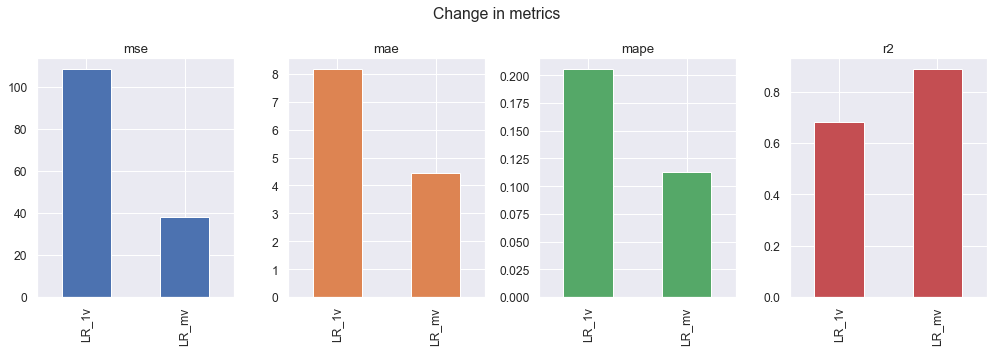

In [385]:
fig,  ax = plt.subplots(figsize=(14, 5))  # specify figure size
metrics_comparison.plot(
    kind='bar', layout=(1,4), subplots=True, 
    title='Change in metrics', legend=False, ax=ax
);
fig.tight_layout();  # prettify subplots. read more in documentation if interested

* did our Linear regression model improve after we've added more features?

Linear regression model has improved after adding features 

### Task 9. Implement Linear regression model with multiple variables yourself (5 points)

Okay, we've fitted Linear regression model using `sklearn` library. Now let's do the math ourselves!

### Prerequisites

For this task you will need to:
* have basic understanding of Linear algebra (operations with vectors and matrices)
* know how to perform matrix multiplication, transposition and inversion using `numpy` 
  (these functions can be found in NumPy documentation)
* carefully read the theory below and refer to wiki / textbooks / other sources if required

---

### Theory and notation

When we extend Linear regression model on case with $m$ variables we get the following formula:

* $ \hat{y}
= 1 \cdot w_0 + x_1 \cdot w_1 + x_2 \cdot w_2 + ... + x_m \cdot w_m
= \sum_{i=0}^{m} x_i w_i
$,

where:
* $x = (1, x_1, ..., x_m)$ is an _(m+1)_-element feature vector. 
    * $x_0 = 1$ is a special term introduced in the beginning of feature vector 
      to add intercept to Linear regression model
    * $x_i, i=\overline{1,m}$ is an _i_-th feature value.
* $w = (w_0, w_1, ..., w_m)$ is an _(m+1)_-element parameter vector
    * $w_0$ - the first value of parameter vector - is referred to as **intercept**
* $\hat{y}$ is a predicted value

----

The formula above is used to calculate predictions for 1 sample.
i.e. we predict 1 scalar $\hat{y}$ from 1 feature vector $x$.

If we have a dataset of $n$ samples $(x, y)$ - we get a system of linear equations:

$
\begin{cases}
 \hat{y}^{(0)} = \sum_{i=0}^{m} x_i^{(0)} w_i \\
 \hat{y}^{(1)} = \sum_{i=0}^{m} x_i^{(1)} w_i \\
 ... \\\
 \hat{y}^{(n-1)} = \sum_{i=0}^{m} x_i^{(n-1)} w_i
\end{cases}
$

Such system can be rewritten in a succinct matrix form (a way that we write equations in Linear algebra):

* $ \hat{y} = X \cdot w $

And the task of minimizing Residual sum of squares (RSS) now looks:
* $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = \|y - X \cdot w \|_2^2 \rightarrow min $

Here:
* $y = (y^{(0)}, y^{(1)}, ..., y^{(n-1)})$ now denotes a **vector of target values** we want to predict<br>
  $y^{(j)}$ is a target value for _j_-th sample in a dataset.
* $\hat{y} = (\hat{y}^{(0)}, ..., \hat{y}^{(n-1)})$ 
  now denotes a **vector of predictions** <br>
  $\hat{y}^{(j)}$ denotes a predicted value for _j_-th sample in a dataset
* $X$ is a **feature matrix** of shape $n \times (m+1)$. <br>
  _n_ rows correspond to _n_ data samples and _m+1_ columns correspond to _m+1_ features that describe each sample.
* $w = (w_0, w_1, ..., w_m)$ is still a **model parameter vector**
* $X \cdot w$ denotes a **matrix-by-vector** multiplication
* $\|\cdot\|_2$ denotes an $L_2$-norm and is basically a square root of sum of squares of vector elements:<br>
  $\|a\|_2 = \sqrt{a_0^2 + a_1^2 + ... + a_{n-1}^2}$ for an _n_-component vector _a_.
  Thus, RSS means the same as before:<br>
  $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = 
  (y^{(0)} - \hat{y}^{(0)})^2 + (y^{(1)} - \hat{y}^{(1)})^2 + ... + (y^{(n-1)} - \hat{y}^{(n-1)})^2 = 
  \sum_{j=0}^{n-1} (y^{(j)} - \hat{y}^{(j)})^2
  $

Note:
* we now use **superscripts** $\hat{y}^{(i)}$ instead of **subscripts** $\hat{y}_i$ as before
  to denote _i_-th sample in a dataset
* it is done to be able to refer both to sample index (denoted by superscript)
  and feature index (denoted by subscript) in a single equation. 
  
  Thus:
  * $x^{(j)} = (1, x^{(j)}_1, x^{(j)}_2, ..., x^{(j)}_{m})$  now denotes 
    _j_-th feature vector in a dataset with _m+1_ features
  * $x_i^{(j)}$ denotes an _i_-th feature value of _j_-th feature vector
  * $X = 
  \begin{bmatrix}
      1 & x^{(0)}_1 & x^{(0)}_2 & ... & x^{(0)}_{m} \\
      1 & x^{(1)}_1 & x^{(1)}_2 & ... & x^{(1)}_{m} \\
      ... \\
      1 & x^{(n-1)}_1 & x^{(n-1)}_2 & ... & x^{(n-1)}_{m}
    \end{bmatrix}
    $ is an $n \times (m+1)$ feature matrix. <br><br>
    $X$ can also be written as a column-vector of feature vectors:<br><br>
    $ X = \begin{bmatrix}x^{(0)} \\ x^{(1)} \\ ... \\ x^{(n-1)}\end{bmatrix} $

---

### Fit 

**<TL;DR\>** Enough notation! How can we fit this model?

By minimizin Residual sum of squares (RSS) for a Linear regression equation in a matrix form
we now get a **single** formula to find **all model parameters**!
* $ w = (X^T X)^{-1} X^T y $

Beautiful, isn't it? <br>
Recall, how we got individual formulas for $w_0, w_1$ in case of Linear regression with 1 predictor.<br>
Now we can find the whole parameter vector _w_ at once!

In the formula above:
* $X$ is an $n \times (m+1)$ dimensional feature matrix


* $X^T$ is a **transposed** feature matrix.<br>
  Transposition is a mathematical operation of "swapping" matrix dimensions.<br>
  So $X^T$ is an $(m+1) \times n$ dimensional matrix  


* $ (X^T X)^{-1} $ is the inverse matrix of $ X^T X $

Notes:
* Because of inversion operation performed on $X^T X$ matrix 
  there are difficulties in fitting Linear regression model in some cases.
  
  We will talk more on that later in the assignment.

---
    
If you want to learn more you can refer to 
[Linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares)
wiki-page.

### Implementation

* implement `LRMatrixForm` class and `add_ones_column` function.<br>
  docstrings describe what each function/method should do - so read the docstrings.
  
  
* [what is a docstring?](https://www.python.org/dev/peps/pep-0257/#what-is-a-docstring)


Note:
* `LRMatrixForm` class must support 2 modes: **with** fitting intercept parameter and **without**.<br>
  The behavior is controlled by `fit_intercept` parameter passed to class constructor.

In [336]:
from sklearn.exceptions import NotFittedError

In [337]:
def add_ones_column(x):
    #Add column consisting of ones to the beginning of matrix `x`. 
    #Used when fitting `LRMatrixForm` with `fit_intercept` param set to True.
    E = np.random.randint(1,2,len(x))
    return np.column_stack((E,x))

class LRMatrixForm:
    #Class that encapsulates Linear regression model with multiplie variables.
    #Calculations are performed using matrix formula.
    
    #Use `fit()` method to fit the model on data.
    #Use `predict()` method to calculate predictions when the model is fitted.
    
    def __init__(self, fit_intercept: bool = True):
        # fit_intercept: 
        #Whether to calculate the intercept for this model. 
        #If set to False, no intercept will be used in calculations 
        #(i.e. data is expected to be centered).
        
        self.fit_intercept = fit_intercept
        self.w_ = None  # vector with all model parameters (intercept and weights)
    
    def fit(self, x_train: pd.DataFrame, y_train: pd.Series):
        X = x_train.to_numpy()  # convert pd.DataFrame to numpy matrix
        Y = y_train.to_numpy() 
        if self.fit_intercept is True:
            # when creating a model with intercept term we need to extend feature matrix
            # with a column consisting of ones (1, 1, ..., 1).
            X = add_ones_column(X)
            
         # your code here to calculate model parameters:
        XT = np.transpose(X)
        self.w_ = np.matmul(np.matmul(np.linalg.inv(np.matmul(XT,X)),XT),Y)
        
    @property
    def coef_(self):
        #Property that returns model parameters without the intercept term. 
        if self.w_ is None:
            raise NotFittedError()
        # your code here:
        if self.fit_intercept is not True:
            return self.w_
            
        return self.w_[1:]
    
    @property
    def intercept_(self):
        #Property that returns intercept term from model parameters.
        if self.fit_intercept is not True:
            return 0.0  # for compatibility with sklearn
        if self.w_ is None:
            raise NotFittedError()
        # your code here:
        return self.w_[0]
    
    def predict(self, x_test: pd.DataFrame):
        #Generate predictions using fitted model parameters. 
        if self.w_ is None:
            raise NotFittedError()
        
        X = x_test.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            X = add_ones_column(X)
            
        # your code here to calculate predictions
        return np.matmul(X, self.w_)

### Validate your implementation is identical to library version

In [338]:
lr_matrix_form = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.744076,4.423665,0.109928,0.879145
test,38.192447,4.459334,0.112574,0.887719


In [339]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: -4.4107609944948045
coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


In [340]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

LRMatrixForm identical to library sklearn

* let's take a look at difference between model predictions and target values:

In [341]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean       -0.000265
std         6.181464
min       -19.832055
25%        -3.624840
50%        -0.929033
75%         2.657819
max        39.721074
Name: dribbling, dtype: float64

Mean difference is low (-0.000265), standart deviation of difference is low (~6.2), predicted target is similar to y_test

### Now let's compare `sklearn` model and yours with `fit_intercept=False`

In [342]:
model = LinearRegression(fit_intercept=False)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,38.001048,4.462836,0.111262,0.878322
test,38.417697,4.494385,0.114204,0.887057


In [343]:
lr_matrix_form = LRMatrixForm(fit_intercept=False)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,38.001048,4.462836,0.111262,0.878322
test,38.417697,4.494385,0.114204,0.887057


* Compare the metrics on a test set of a model fitted **with** intercept parameter 
  vs model fitted **without** intercept.
* Which model has a better performance? Can you explain why?

Test set of model fitted with intercept parameter has better metrics and better performance then model fitted without intercept. It can be explained as model without intercept actually has less parameters to construct prediction model. Having intercept equal to 0, coefficient are being changed to fit model, it may be not so accurate. 

In [344]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: 0.0
coef: [ 0.99382995 -0.05758452 -0.17865978  0.18315944]


In [345]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values again:

In [346]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean        0.069583
std         6.199275
min       -20.437460
25%        -3.706841
50%        -0.888994
75%         2.766454
max        39.316868
Name: dribbling, dtype: float64

* compare this to the same statistics obtained with model fitted **with intercept**
* notice how the _mean_ value of difference changed

Statistics show that model without intercept is more inaccurate. The absolute value of difference mean is more then in model fitted with intercept (~in 100 times). Moreover, it changed to positive. It means, that ammount of predicted targets which is higher than true values become more. Predicted model without intercept contains an origin. But model with intercept, which was negative, had part close to origin, that was below. Correspondently, target values was below and mean difference was negative.       

## Limitations of Linear regression

Recall the formula to find Linear regression parameters in case of multiple variables:
* $ w = (X^T X)^{-1} X^T y $

As noted above, there might be difficulties with fitting Linear regression model
because of inverting $X^T X$ matrix.

Not every matrix can be inverted.

An example of such case is when 2 or more features have strong linear relationship between them.<br>
It means that one of variables can be **linearly predicted from the others with a substantial degree of accuracy**.<br>
Such situation is named **collinearitry** (in case of 2 related variables)
or **multicollinearity** (>2 related features).<br>

Collinearity is associated with high value of correlation coefficient between 2 related features.

You can refer to [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) 
wiki page to read more.

The intuition why multicollinearity is bad is that Linear Regression tries to capture 
a contribution of each individual feature to target independently of other features.
This is not possible with the data that has collinear features, 
as change in one such variable is always associated with change in other/others.

There are a whole bunch of really interesting thoughts that can help you 
to capture the intuition behind the concept of multicollinearity.<br>
You can find some of them 
[here](https://stats.stackexchange.com/questions/1149/is-there-an-intuitive-explanation-why-multicollinearity-is-a-problem-in-linear-r).

### Collinearity

* Let's construct and add a new feature to our dataset that is going to be _collinear_ with another one:

In [347]:
# select features as usual
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

In [348]:
def add_collinear_column(_df: pd.DataFrame, orig_col: str, new_col: str):    
    #Construct new column as a linear transform of another one + tiny noise.
    #y = f(x) = a1 * x + a2 + noise.
    
    #Alternatively, we could apply no linear transform at all (set a1=1, a2=0)
    #And only add some noise to existing column. Results would be the same.
    
    # linear transform
    _df[new_col] = 2 * _df[orig_col] + 3
    # add tiny normal noise
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

orig_col = 'sprint_speed'
new_col = 'sprint_speed_2'
add_collinear_column(x_train, orig_col, new_col)
add_collinear_column(x_test, orig_col, new_col)
features.append(new_col)

In [349]:
corr_coef = np.corrcoef(x_train[orig_col], x_train[new_col])[0, 1]
print(f'correlation between {orig_col} and {new_col}: {corr_coef}')

correlation between sprint_speed and sprint_speed_2: 0.9999999999935615


* As expected, correlation coefficient between collinear features 
  (`sprint_speed` and `sprint_speed_2`) is close to 1.<br>
  Thus they are highly correlated.

In [350]:
# visualize sample of train data
check = x_train.sample(5).copy()
# add helper column to see how much noise was added
check['sprint_speed_2_no_noise'] = 2 * check['sprint_speed'] + 3
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,sprint_speed_2_no_noise
108417,56.0,62.0,82.0,78.0,158.999980,159.0
66810,25.0,37.0,80.0,40.0,83.000205,83.0
47869,75.0,69.0,63.0,65.0,132.999940,133.0
146164,66.0,67.0,68.0,58.0,118.999972,119.0
24385,78.0,78.0,74.0,64.0,131.000134,131.0


### let's fit a Linear Regression model on this feature set:

In [351]:
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.744048,4.423747,0.109929,0.879145
test,38.190873,4.459329,0.112569,0.887724


* Both train and test metrics look reasonable
* Now let's explore model params:

In [352]:
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')
print(f'parameters: {features}')

intercept: -164.07310919312002
coef: [0.9822014422256165, -0.039279941161662474, -0.1444031910331534, -106.2335067466802, 53.22062111008171]
parameters: ['ball_control', 'short_passing', 'strength', 'sprint_speed', 'sprint_speed_2']


* Weights that correspond to `sprint_speed` and `sprint_speed_2` columns should have gone insanely high!


* That is not ok. Large weights and weights instability are the sign of 
    [**overfitting**](https://en.wikipedia.org/wiki/Overfitting).

    According to the definition, overfitting is:<br>
    "_the production of an analysis that corresponds too closely 
    or exactly to a particular set of data,<br>
    and may therefore fail to fit additional data 
    or predict future observations reliably_".
    
    
* But what does that mean? Let's try to generate predictions with our model.

### generate predictions using our fitted model

In [353]:
check = x_test.head(2).copy()
check[target] = y_test.head(2)
check['preds'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds
147541,51.0,60.0,68.0,52.0,106.999968,49.0,44.305359
147549,65.0,69.0,66.0,69.0,141.000232,59.0,61.537039


In [354]:
get_metrics(y_true=check[target], y_pred=check['preds'])

mse     14.238110
mae      3.615840
mape     0.069405
r2       0.430476
dtype: float64

* predictions look good, right?

No anomaly, but r2 is less then 0.5

### but what if we change `sprint_speed` values a bit? let's add some small `delta`

In [355]:
delta = 1  # some small value
check['sprint_speed'] += delta
check['preds_2'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds,preds_2
147541,51.0,60.0,68.0,53.0,106.999968,49.0,44.305359,-61.928148
147549,65.0,69.0,66.0,70.0,141.000232,59.0,61.537039,-44.696468


In [356]:
get_metrics(y_true=check[target], y_pred=check['preds_2'])

mse     11529.005739
mae       107.312308
mape        2.010704
r2       -460.160230
dtype: float64

* Wow, new predictions doesn't look even close to the target!<br>
  Our model doesn't look like a good model anymore.
  

* That is exactly what overfitting is. <br>
  **We fail to obtain reasonable predictions when we apply our model on new data**.

### One might notice that we have changed only 1 of 2 collinear features
* Indeed, giant model weights that correspond to these 2 features, should cancel each one out<br>
  if relation between feature values stays the same.  

* Let's check this out.<br>
  We have performed following transform:<br>
  `sprint_speed_changed = sprint_speed + delta`<br>
  

* How should we change `sprint_speed_2` to match the same data distribution from train data?<br>
  
  Let's calculate (we will ignore the noise added):  
  `sprint_speed_2_changed - sprint_speed_2 = f(sprint_speed_changed) - f(sprint_speed) =`<br>
  `= a1 * sprint_speed_changed + a2 - (a1 * sprint_speed + a2) = a1 * delta`

In [357]:
# here we change the second of collinear features 
# using the same coefficient 
# that was used in linear transform in `add_collinear_column()` function.
# we don't need to add intercept coefficient as it cancels it out (you can do the math yourself).
check['sprint_speed_2'] += 2 * delta
check['preds_3'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds,preds_2,preds_3
147541,51.0,60.0,68.0,53.0,108.999968,49.0,44.305359,-61.928148,44.513094
147549,65.0,69.0,66.0,70.0,143.000232,59.0,61.537039,-44.696468,61.744774


* In the last example we see that new predictions (`preds_3`) now look similar to the first ones <br>
  (`preds` - calculated before changing `sprint_speed` value)


* So, if values of collinear features change accordingly - we are safe, right? <br>
  How do your think, can we always rely on this assumtion? - no

### What just happened

* The answer to the question above is: **no, we can't**.
  
  
* Yes, we have checked that if collinear features values are changed accordingly 
  (i.e. their **initial relation is preserved**), <br>
  model predictions look reasonable and accurate.
  
  But this will not always be the case on the real data.
  
  We can't be sure that the data 
  that we apply our fitted model on (`x_test`, for example)<br>
  preserves **exactly the same data distribution** as the data that model was trained on (`x_train`).
  
  

**Why this happened?**

* When feature matrix contains collinear or multicollinear features (the problem of **multicollinearity**),
  inversion of such a matrix is numerically unstable.<br>
  This leads to large values and imprecise estimates of model parameters.

**How to detect multicollinearity**
* You should monitor your model weights. For example using $L_2$ norm:<br>
  $ L_2(w) = \|w\|_2 = \sqrt{w_1^2 + w_2^2 + ... + w_n^2} = \sqrt{\sum_{i=1}^{n} w_i^2} $<br>
  If any of model weights are huge - $L_2$ norm will also have large value.
  
  
* Monitor model performance on validation data. 
  If the metrics are poor and prediction look huge,<br>
  you should check if collinear features are present in train data.

**How to fix the issue**

* For each set of collinear features, keep only 1 of them and remove the rest.<br>
  The best regression models are those in which the predictor variables each correlate highly 
  with the target variable,<br>
  but correlate at most only minimally with each other.
  

* Combine collinear features into new ones

  
* Use regularization (will be covered later in the course).

### Task 10. Implement function to calculate $L_2$-norm. (1 point)
* Use formula above to implement $L_2$ norm

In [358]:
def l2_norm(arr: Iterable):
    # your code here
    return (np.square(arr).sum())**0.5

### Calculate $L_2$-norm value for current model
* you should get high value that represents large values of some model parameters

In [359]:
l2_norm(model.coef_)

118.82331245133798

$L_2$-norm value for current model is huge, collinear features are present in train data.

### Multicollinearity
  
* It's important to notice that in case of multicollinearity,
  correlation coefficient between each pair of related variables
  could be **not so high**.
  
  So **it may be hard to find multicollinear features in your data**.
  

* Let's visualize it in practice.

  We will build a new feature that has a strong linear relationship with 2 other features:
  $x_1 = a_0 + a_2 x_2 + a_3 x_3 + noise$

  We want to show that Linear regression model will still suffer from multicollinearity,<br>
  but correlation coefficients betweent each pair of multicollinear features will be **less close to 1**
  than it was in case of collinearity.

In [360]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

def add_collinear_column(_df: pd.DataFrame, col1: str, col2: str, new_col: str):    
    _df[new_col] = _df[col1] + _df[col2] + 5
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

add_collinear_column(x_train, col1='sprint_speed', col2='strength', new_col='foo')
add_collinear_column(x_test, col1='sprint_speed', col2='strength', new_col='foo')
features.append(new_col)

model = LinearRegression(fit_intercept=True)
m = fit_and_evaluate(model, x_train, y_train, x_test, y_test)
display(m)
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

,mse,mae,mape,r2
train,37.744075,4.423674,0.109928,0.879145
test,38.192991,4.459369,0.112575,0.887717


intercept: -59.37935122773846
coef: [0.9822047292574339, -0.03927785213628547, -11.138135332396969, -10.785995248580036, 10.993725105746591]


* As before, model parameters for multicollinear features should be large

* Let's calculate $L_2$-norm value - it should also be large

In [361]:
l2_norm(model.coef_)

19.032183604771888

#### Task 11. Visualize correlation matrix for `x_train`  (1 point)
* Build annotated heatmap (use `annot` param to add values to plot, select diverging `cmap` and center it at 0)
* You should see that `foo` feature is correlated with ones it was created from,<br>
  but each of these correlation coefficients **is not so close to 1**

,ball_control,short_passing,strength,sprint_speed,foo
ball_control,1.000000,0.904857,-0.024422,0.572677,0.474099
short_passing,0.904857,1.000000,0.039196,0.450801,0.415056
strength,-0.024422,0.039196,1.000000,-0.203386,0.541851
sprint_speed,0.572677,0.450801,-0.203386,1.000000,0.712702
foo,0.474099,0.415056,0.541851,0.712702,1.000000


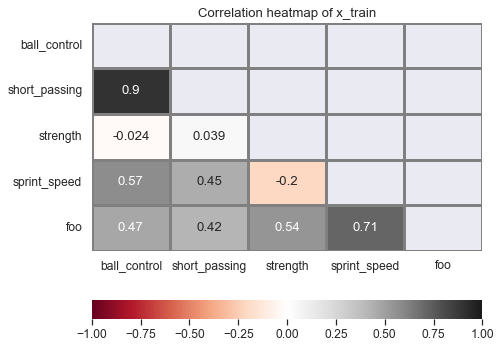

In [362]:
correlation_x_train = x_train.corr()
display(correlation_x_train)
sns.heatmap(correlation_x_train, annot=True, mask=np.triu(correlation_x_train), cbar_kws= {'orientation': 'horizontal'}, 
            vmin=-1, vmax=1, center= 0, cmap= 'RdGy', linewidths=3, linecolor='grey')
plt.title('Correlation heatmap of x_train')
plt.show()

'foo' feature is correlated with features it was created from ('strength', 'spirit_speed' ),
but each of these correlation coefficients is not so close to 1

### Regularization

* The concept of regularization (that was mentioned above) is simple.

  We modify Loss function (RSS in case of Linear regression) in such a way<br>
  to penalize for large values of model parameters.
  
  
* $L_2$ regularization, also named as 
  [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization), 
  adds $L_2$ term to loss function:

  $L(w,x,y) = RSS(w,y) + \alpha L_2(w) = \|y - \hat{y}\|_2^2 + \alpha \|w\|_2^2 
  = \|y - X \cdot w \|_2^2 + \alpha \|w\|_2^2$
  
  parameter $ \alpha \ge 0 $ controls the ammount of regularization applied
  

* Linear regression implemented with $L_2$ regularization is named a **Ridge regression**.


* Ridge regression is implemented in `Ridge` class in `sklearn` library

---

Let's see how applying regularization changes our model.

In [363]:
from sklearn.linear_model import Ridge

* at first fit `Ridge` without any regularization to ensure we get similar results 
  to using `LinearRegression`

In [364]:
# `solver` parameters determines the algorithm used to solve regression task.
# we fix it to be `svd` to achieve desired results.
model_r = Ridge(alpha=0, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.744075,4.423674,0.109928,0.879145
test,38.192991,4.459369,0.112575,0.887717


In [365]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: -59.379351227777114
coef: [0.982204729257431, -0.039277852136285436, -11.138135332404705, -10.78599524858777, 10.993725105754327]
l2 norm: 19.032183604785267


* some model parameters should be large, as well as the $L_2$-norm value
* now, let's add some regularization

In [366]:
model_r = Ridge(alpha=0.01, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.744076,4.423665,0.109928,0.879145
test,38.192449,4.459334,0.112574,0.887719


In [367]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: -4.671429503120976
coef: [0.9822051866331643, -0.039277640849541176, -0.1965425728433119, 0.15559477480038786, 0.052133674183390766]
l2 norm: 1.015788559981213


* notice how parameter values changed
* also notice how $L_2$-norm values decreased

## Task 12. Putting all together. (up to 10 points)

In the final task we'll try to recap all that we have learnt so far.

Your task is to build a Linear regression model with multiple variables to predict `agility` variable.<br>
Only `LinearRegression` class is allowed to be used for modeling.<br>

Steps you need to follow:

* Make a new train/test split with new proportion: 70% on train and 30% on test data **(1 point)**


* Fit a model **(up to 6 points)**
    
    * Choose >= 10 features from training set as initial set of features
      Explain your choice. **(1 point)**
      
    * Visualize correlation matrix for selected features **(1 point)**
    
    * Analyze if collinear/multicollinear features are present in your feature set.<br>
      Process collinear/multicollinear features if they are present:<br>
      remove redundant features, combine features into new ones, etc **(up to 3 points)**
     
    * Fit the model and calculate metrics on train and test sets<br>
      **(1 point max. -0.25 points per each metric that was not implemented in the beginning of the assignment)**
    

* Analyze fitted model performance **(up to 2 points)**:
    * Print fitted model parameters and calculate their $L_2$-norm value **(1 point)**
    * Make conclusion whether your model overfitted or not. Provide your arguments. **(1 point)**


* Write a short report about the work done **(1 point)**<br>
  Can you find a logical explanation for high correlation of some of your features?<br>
  Are you satisfied with the quality of predictions?<br>
  How could you pottentially improve the model?<br>
  Any other thoughts.


**Penalties:**
- **0 points are assigned for the whole task** if used a model different from:
    - `sklearn.linear_model.LinearRegression`
    - or `LRMatrixForm`

Make column 'agility' first in df_aj 

In [368]:
col_new = list(df.columns)
col_new.remove('agility')
col_new.insert(0, 'agility')
df_aj = df.reindex(col_new, axis = 'columns')

Show correlation heatmap for all features:

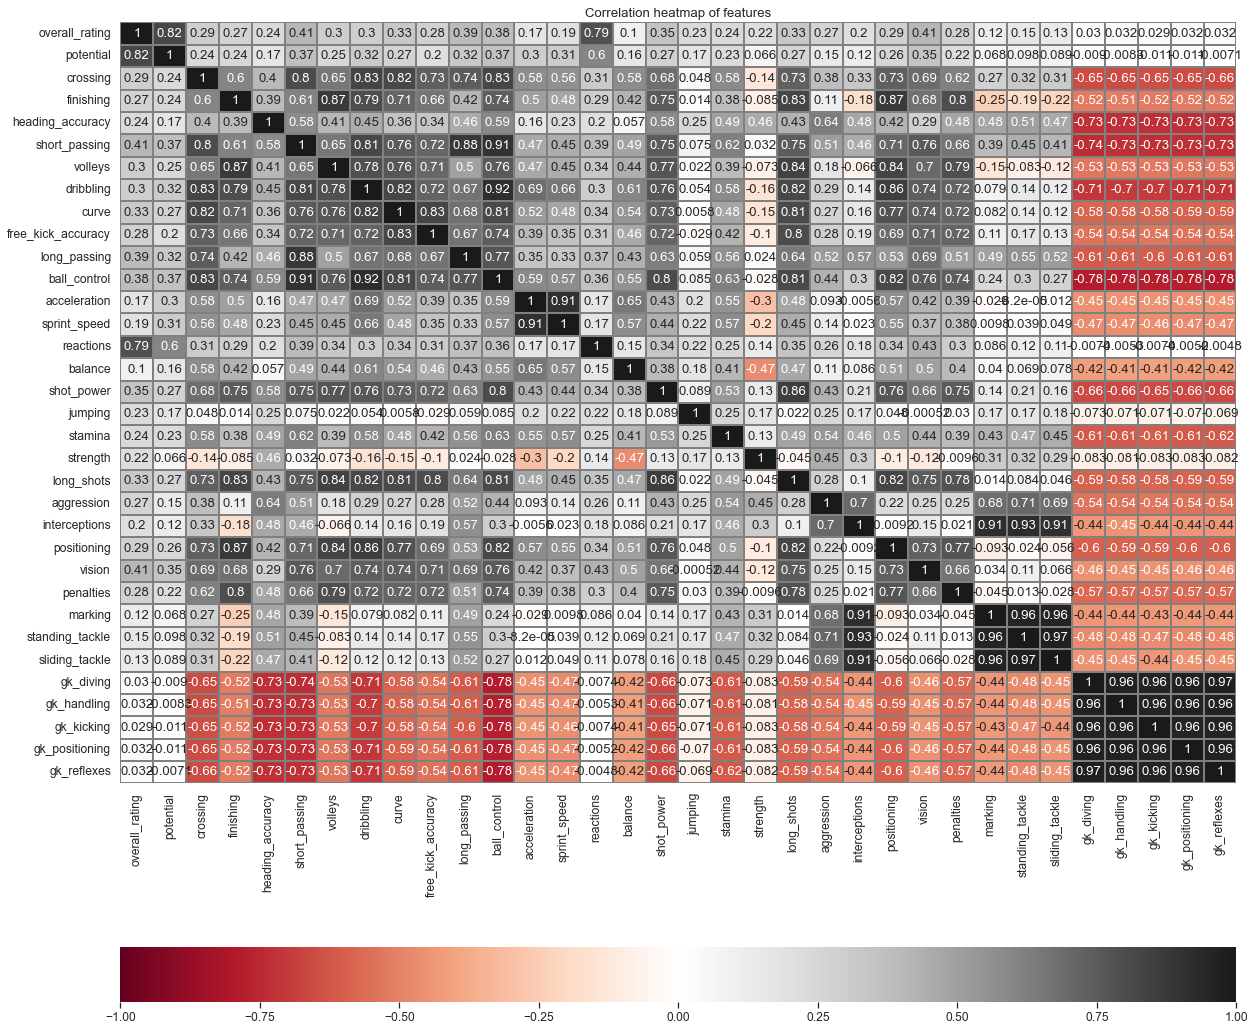

In [369]:
target = 'agility'
correlation_aj = df_aj.corr()
pl_aj=plt.figure(figsize=(20, 20))
pl_aj=sns.heatmap(correlation_aj.drop(target, axis=0).drop(col_new[0], axis=1), 
                  cbar_kws= {'orientation': 'horizontal'}, 
                  annot=True, vmin=-1, vmax=1, center= 0, cmap= 'RdGy', linewidths=0.4, linecolor='grey')
plt.title('Correlation heatmap of features')
plt.show(pl)

We can see a lot of feature pairs with high correlation (> 0.8)

Let's look at correlation heatmap for target 'agility' with features:

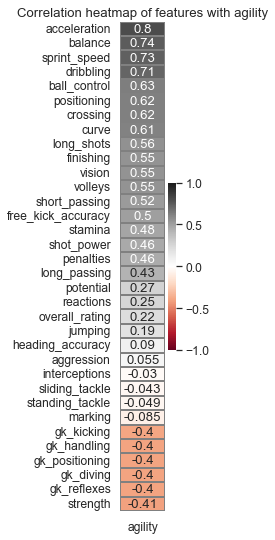

In [370]:
pl_aj=plt.figure(figsize=(1, 9))
pl_aj=sns.heatmap(correlation_aj.sort_values(by=target, ascending=False).drop(target, axis=0).drop(col_new[1:], axis=1), 
                  annot=True, vmin=-1, vmax=1, center= 0, cmap= 'RdGy', linewidths=0.4, linecolor='grey')
plt.title('Correlation heatmap of features with agility')
plt.show(pl)

For further investiation we will drop features which have low correlation (-0.15 < corr < 0.15) with target. These features hardly influence on target prediction. 

Split football dataset into 70/30 proportion fot train and test datasets: 

In [371]:
ix_split = int(0.7 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(f'Shape of train and test datas(70/30 proportion):{DF_TRAIN.shape, DF_TEST.shape}')

Shape of train and test datas(70/30 proportion):((7407, 35), (3175, 35))


Write additional function, which teach prediction model, measure difference statistics, l2 norm and metrics on test and prediction sets:

In [372]:
def pred(x_train, y_train, x_test, y_test):   
    model = LinearRegression(fit_intercept=True)
    model.fit(x_train, y_train);
    model_intercept = model.intercept_
    model_coef = model.coef_
    L2 = (np.square(model_coef).sum())**0.5
    print(f'\nmodel_intercept: {model_intercept}')
    print(f'model_coef:\n{model_coef}')
    print(f'L2_norm:{L2}')

    model_preds = model.predict(x_test)
    model_preds_train = model.predict(x_train)
    model_stat = (model_preds - y_test).describe(percentiles = [0.5])
    metrics = [mse_lib(y_test, model_preds),mae_lib(y_test, model_preds), \
             mape_lib(y_test, model_preds), r2_lib(y_test, model_preds)] 
    metrics_train = [mse_lib(y_train, model_preds_train),mae_lib(y_train, model_preds_train), \
             mape_lib(y_train, model_preds_train), r2_lib(y_train, model_preds_train)] 

    print(f'\nerror statistics:\n{model_stat}\n\nmse: {metrics[0]}\
            \nmae: {metrics[1]}\nmape: {metrics[2]}\nr2: {metrics[3]}')
    print(f'\nmse_train: {metrics_train[0]}\nmae_train: {metrics_train[1]}\
            \nmape_train: {metrics_train[2]}\nr2_train: {metrics_train[3]}')
    return model_stat, metrics, L2, metrics_train

Write additional function, which measure r2 coefficient for every feature as target in test set. We will need it for features collinearity analize

In [373]:
def r2_feature(df, features):
    r2_feature = {}
    for feature in features:
        X = [f for f in features if f != feature]
        X, Y = df[X], df[feature]
        r2 = LinearRegression().fit(X, Y).score(X, Y)
        r2_feature[feature] = r2
        
    return pd.DataFrame({'r2' : r2_feature})

Select features with absolute correlation more then 0.15:

In [374]:
corr_min = 0.15
feature_col = list(correlation_aj.sort_values(by=target, ascending=False)\
                   .loc[(abs(correlation_aj[target]) >= corr_min) & (correlation_aj['agility'] < 1)].index)
#len_1 = len(feature_col)
print(f'Choosen absolutely correlation (features with target) > {corr_min}\n')
print(f'We will try to predict \'agility\' using {len(feature_col)} features:\n{feature_col}')

Choosen absolutely correlation (features with target) > 0.15

We will try to predict 'agility' using 28 features:
['acceleration', 'balance', 'sprint_speed', 'dribbling', 'ball_control', 'positioning', 'crossing', 'curve', 'long_shots', 'finishing', 'vision', 'volleys', 'short_passing', 'free_kick_accuracy', 'stamina', 'shot_power', 'penalties', 'long_passing', 'potential', 'reactions', 'overall_rating', 'jumping', 'gk_kicking', 'gk_handling', 'gk_positioning', 'gk_diving', 'gk_reflexes', 'strength']


Using seleced features create test and train sets:

In [375]:
y_train = DF_TRAIN[target].copy()
y_test = DF_TEST[target].copy()
x_train = DF_TRAIN[feature_col].copy()
x_test = DF_TEST[feature_col].copy()

Make a prediction model. Show model parameters and l2 norm, statistic of test prediction error, show metrics of train and test prediction: 

In [376]:
model_stat_1, metrics_1, L2_1, metrics_train_1 = pred(x_train, y_train, x_test, y_test);


model_intercept: 9.720132462634382
model_coef:
[ 3.29353659e-01  2.31106252e-01  9.65969703e-02  1.33852532e-01
  1.22579279e-01  2.15805675e-03 -3.35086911e-02  5.24317600e-02
 -1.49024948e-02  2.32959936e-02  5.49022655e-02  1.31536430e-02
 -8.45452892e-03  1.81791353e-02  5.17411154e-02 -1.13502301e-02
 -2.98157638e-02  9.30444380e-05 -1.44767432e-01  6.86201354e-02
 -1.43047978e-02  7.52385537e-02  2.40157863e-02  3.18004037e-02
  2.09047311e-02  6.13287339e-02  1.58108290e-02 -1.52754370e-01]
L2_norm:0.5262932404408832

error statistics:
count    3175.000000
mean       -0.012146
std         6.683948
min       -28.826369
50%        -0.215386
max        41.398802
Name: agility, dtype: float64

mse: 44.66123863900008            
mae: 5.035178456646478
mape: 0.090999020300985
r2: 0.7736324364078393

mse_train: 40.890535091295675
mae_train: 4.882787498827793            
mape_train: 0.08694472502170013
r2_train: 0.7818953662032775


We can see, that model coefficients are close to 0, L2-norm less then 1. It means that model stable and not overfitted. Mean difference on train and predicted values low (~ -0.012), standart deviation of difference is low (~ 6.68). Metrics of test and train set prediction are similar. mean absolute error is about 5 and r2 is rather high (~ 0.78), it means that target prediction set has good correlation with test target set.

Let's look how features correlates with each other. Show r2 for each feature as if it would be predicted from others:

In [377]:
print(r2_feature(x_train, feature_col))

                          r2
acceleration        0.867261
balance             0.632113
ball_control        0.941756
crossing            0.808203
curve               0.819875
dribbling           0.915030
finishing           0.865558
free_kick_accuracy  0.763496
gk_diving           0.958526
gk_handling         0.952348
gk_kicking          0.942844
gk_positioning      0.954374
gk_reflexes         0.958094
jumping             0.250963
long_passing        0.833836
long_shots          0.863922
overall_rating      0.854667
penalties           0.729548
positioning         0.855506
potential           0.727392
reactions           0.655548
short_passing       0.912253
shot_power          0.811636
sprint_speed        0.846410
stamina             0.597109
strength            0.536913
vision              0.741039
volleys             0.824727


We can see that several of features have high r2 coefficient (more than 0,85), it means that they are highly correlated with others features and may be droped without prediction model degrading.

Let's drop feature one by one and look how model parameters changing: 
- remove gk_ features with highest r2 

In [387]:
feature_new = feature_col[:]
feature_new.remove('gk_diving')
feature_new.remove('gk_reflexes')
feature_new.remove('gk_positioning')
feature_new.remove('gk_handling')
x_train = DF_TRAIN[feature_new].copy() 
x_test = DF_TEST[feature_new].copy()
print(r2_feature(x_train, feature_new))
pred(x_train, y_train, x_test, y_test);

                          r2
acceleration        0.867202
balance             0.631708
ball_control        0.938804
crossing            0.807907
curve               0.819785
dribbling           0.914887
finishing           0.865402
free_kick_accuracy  0.763426
gk_kicking          0.805971
jumping             0.249743
long_passing        0.833817
long_shots          0.863514
overall_rating      0.848954
penalties           0.728814
positioning         0.855493
potential           0.727000
reactions           0.654999
short_passing       0.911261
shot_power          0.810360
sprint_speed        0.846140
stamina             0.592499
strength            0.531475
vision              0.737884
volleys             0.824693

model_intercept: 10.483457489974292
model_coef:
[ 3.31032830e-01  2.30311085e-01  9.38693491e-02  1.36331201e-01
  9.49751809e-02  2.28837343e-03 -3.41362861e-02  5.30096550e-02
 -1.14460317e-02  2.48118068e-02  6.12121679e-02  1.31861036e-02
 -2.02011866e-02  1.75984482e-0

We can see, that model coefficients are close to 0, L2-norm less then 1. It means that model remain stable. Error statistics and metrics on train and test sets didn't change a lot and absolute value of mean difference less. 

- next remove ball_control and short_passing features

In [388]:
feature_new.remove('ball_control')
feature_new.remove('short_passing')
x_train = DF_TRAIN[feature_new].copy() 
x_test = DF_TEST[feature_new].copy()
print(r2_feature(x_train, feature_new))
pred(x_train, y_train, x_test, y_test);

                          r2
acceleration        0.867116
balance             0.631052
crossing            0.806589
curve               0.819040
dribbling           0.892301
finishing           0.865345
free_kick_accuracy  0.763075
gk_kicking          0.734660
jumping             0.248716
long_passing        0.751069
long_shots          0.863353
overall_rating      0.844640
penalties           0.726532
positioning         0.854526
potential           0.724688
reactions           0.654362
shot_power          0.809684
sprint_speed        0.845753
stamina             0.591467
strength            0.530649
vision              0.729460
volleys             0.824638

model_intercept: 10.503987123580288
model_coef:
[ 0.33179216  0.23188578  0.09189587  0.16752921  0.00496816 -0.03339136
  0.05561082 -0.0123497   0.02586481  0.06569921  0.01403274  0.01605212
  0.04708035 -0.01306552 -0.02917344  0.0043612  -0.13671743  0.07336034
  0.0426086   0.07417112  0.10520566 -0.15897844]
L2_norm:0.53026

Model have good parameters and remain stable. Error statistics and metrics on train and test sets didn't change a lot and absolute value of mean difference is less. We don't drop feature 'dribbling' and 'sprint_speed' despite of its high r2 coefficient. That is because it lead to worse model prediction.

- drop other reatures which r2 coefficient more then 0.8:

In [389]:
feature_new.remove('acceleration')
feature_new.remove('positioning')
feature_new.remove('crossing')
feature_new.remove('curve')
feature_new.remove('long_shots')
feature_new.remove('finishing')
feature_new.remove('volleys')
feature_new.remove('shot_power')
feature_new.remove('overall_rating')
x_train = DF_TRAIN[feature_new].copy() 
x_test = DF_TEST[feature_new].copy()
print(r2_feature(x_train, feature_new))
pred(x_train, y_train, x_test, y_test);

                          r2
balance             0.608780
dribbling           0.835055
free_kick_accuracy  0.673947
gk_kicking          0.695682
jumping             0.233977
long_passing        0.667619
penalties           0.642156
potential           0.464917
reactions           0.511282
sprint_speed        0.624624
stamina             0.573422
strength            0.459967
vision              0.700874

model_intercept: 11.245529488611027
model_coef:
[ 0.27499122  0.32999829  0.2394045   0.07218291  0.02975938  0.06545463
 -0.01472251 -0.03301564 -0.09474972  0.08438988  0.08198262  0.12589017
 -0.1935292 ]
L2_norm:0.5741453173172928

error statistics:
count    3175.000000
mean       -0.009340
std         6.906135
min       -29.241653
50%        -0.306886
max        42.436757
Name: agility, dtype: float64

mse: 47.67976573167352            
mae: 5.238295582089629
mape: 0.09461741744957423
r2: 0.7583328915580301

mse_train: 44.56259061377936
mae_train: 5.11312726061393            
mape_

Model remains stable. Let's compare r2 coefficient of features and features correlation with target and choose next features to remove. 

- drop 'free_kick_accuracy', 'long_passing', 'potential' features. We don't drop features with higher r2 coefficient as they have high correlation with target feature and have high 'weights'

In [381]:
feature_new.remove('free_kick_accuracy')
feature_new.remove('long_passing')
feature_new.remove('potential') 
len_2 = len(feature_new)
x_train = DF_TRAIN[feature_new].copy() 
x_test = DF_TEST[feature_new].copy()
print(r2_feature(x_train, feature_new))
model_stat_2, metrics_2, L2_2, metrics_train_2 = pred(x_train, y_train, x_test, y_test);

                    r2
balance       0.601458
dribbling     0.825626
gk_kicking    0.650564
jumping       0.227789
penalties     0.583941
reactions     0.379914
sprint_speed  0.581592
stamina       0.555923
strength      0.456078
vision        0.651540

model_intercept: 7.682414167327394
model_coef:
[ 0.27877506  0.32199226  0.23414189  0.06485469  0.0609681   0.00258123
  0.04508305  0.07904609  0.12386624 -0.19962684]
L2_norm:0.5546362435453609

error statistics:
count    3175.000000
mean       -0.000068
std         6.946779
min       -28.823843
50%        -0.291118
max        41.837950
Name: agility, dtype: float64

mse: 48.2425426735239            
mae: 5.273021099733492
mape: 0.09523501231456553
r2: 0.7554804304742198

mse_train: 44.94243562611801
mae_train: 5.125283333762349            
mape_train: 0.0913792201734553
r2_train: 0.7602830718091087


Finally, model coefficients are close to 0 and L2-norm (~ 0.55) is low. It means that model isn't overfitted and stable. Moreover, r2 coefficient for each feature in model isn't very high (< 0,83), that is features have low influence of collinearity.

Differences statistics of model prediction values and test values rather good. Mean of difference is low (~ -0,00007), difference standart deviatiov is low (~ 7).

Metrics shows good correlation with test set. r2 coefficient about 0,75, that is close to 1, means good predictivity. Mean absolute error of prediction is low (~ 5.3), model predict target values with absolute error about 9,5%

Let's check how finally selected features correlates with each other and target:

Compare initial and final model parameters, show plot 

In [382]:
index = ['model_1', 'model_2']
model_stat = pd.DataFrame([model_stat_1[1:], model_stat_2[1:]],index = index)
model_stat['L2'] = [L2_1, L2_2]
model_stat['f_size'] = [len_1, len_2]
model_metrics = pd.DataFrame([metrics_1, metrics_2], index = index, columns = ['mse', 'mae', 'mape', 'r2'])
models = pd.concat([model_stat.T, model_metrics.T]).T

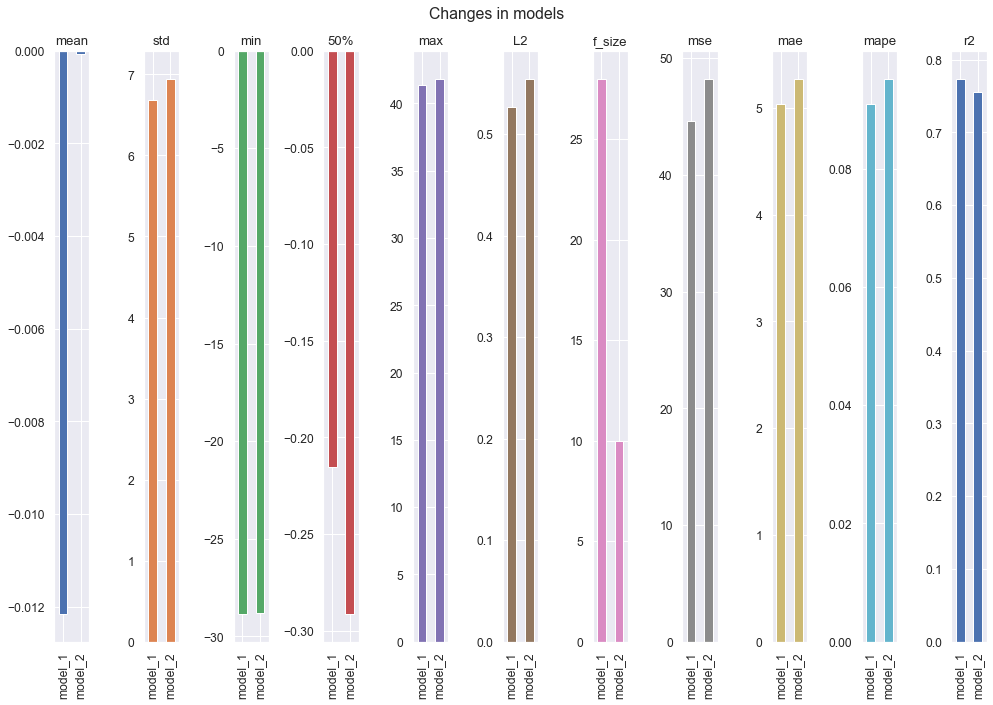

In [384]:
fig,  ax = plt.subplots(figsize=(14, 10)) 
models.plot(
    kind='bar', layout=(1,11), subplots=True, 
    title='Changes in models', legend=False, ax=ax
);
fig.tight_layout(); 

We can see that final model (model 2) metrics and statistics not much worse then in initial model (model 1). But it use less features and has lower mean difference between test and predicted values. Model 2 is more optimal and have better performance.

**Summary**

- For last task was selected **28** features with **absolute correlation coefficient > 0.15**, then, by comparing **r2** features values, correlation coefficient and model parameters, some features were removed. Final ammount of features fo prediction is **10**.

- Model has **low coefficients** close t 0 and **L2-norm (0.55)**, that mean that **model isn't overfitted

- Some features for model prediction has high correlation (for example, 'dribbling' and 'vision' 0,74), but they have different coefficient (~0,23 and ~0,065 accordingly)

- Metrisc shows good model performance. **r2 coefficient (0,75)** is rather higth and close to 1, means good correlatin with test set. Mean absolute error of prediction is low **(mse ~ 5.3)**, model predict target values with absolute error **(mape) 9,5%**
